<a href="https://colab.research.google.com/github/Rahul711sharma/Credit-Card-Default-/blob/main/Credit_Card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objective**

* ## To predict the chances of Credit Card Default made by the Client.


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

##Importing Libraries

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.4MB 65kB/s 
     |████████████████████████████████| 204kB 20.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=3a88cecdea82400dc00c1116b520db8f5fdaa1e02ce5aececf32944a7e85c755
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [ ]:
import pyspark
import pyspark.sql as sql

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotly.express as pe
import sklearn.metrics as met
%matplotlib inline

In [ ]:
sc = pyspark.SparkContext()

In [ ]:
sqlContext = pyspark.SQLContext(sc)

## Importing Data

In [ ]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls")
df.head(3)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [ ]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls",header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
sql_df = sqlContext.createDataFrame(df)

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
sql_df.select('*').limit(10).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Describe Data

In [ ]:
sql_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- LIMIT_BAL: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- EDUCATION: long (nullable = true)
 |-- MARRIAGE: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PAY_0: long (nullable = true)
 |-- PAY_2: long (nullable = true)
 |-- PAY_3: long (nullable = true)
 |-- PAY_4: long (nullable = true)
 |-- PAY_5: long (nullable = true)
 |-- PAY_6: long (nullable = true)
 |-- BILL_AMT1: long (nullable = true)
 |-- BILL_AMT2: long (nullable = true)
 |-- BILL_AMT3: long (nullable = true)
 |-- BILL_AMT4: long (nullable = true)
 |-- BILL_AMT5: long (nullable = true)
 |-- BILL_AMT6: long (nullable = true)
 |-- PAY_AMT1: long (nullable = true)
 |-- PAY_AMT2: long (nullable = true)
 |-- PAY_AMT3: long (nullable = true)
 |-- PAY_AMT4: long (nullable = true)
 |-- PAY_AMT5: long (nullable = true)
 |-- PAY_AMT6: long (nullable = true)
 |-- default payment next month: long (nullable = true)



In [ ]:
sql_df.summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|            PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|        BILL_AMT4|         BILL_AMT5|        BILL_AMT6|          PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+-

In [ ]:
type(sql_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
sql_df.toPandas().shape

(30000, 25)

##Null Values In data

In [ ]:
sql_df.filter(sql_df.SEX.isNull()).count()

0

In [ ]:
sql_df.toPandas().isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

##Exploratory Data 

### Categorical Data Exploration

In [ ]:
sql_df.createOrReplaceTempView('data')

In [ ]:
sql_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [ ]:
spark.sql(f"select SEX,count(*) as Count from data group by SEX").show()

+---+-----+
|SEX|Count|
+---+-----+
|  1|11888|
|  2|18112|
+---+-----+



In [57]:
# Function to find distinct Values

def distinct_values(data):
  for i in data.columns:
    #distinct values with less than 30 unique values
    if len(set(list(data[i])))<30:
      print(f"{i} Distinct Values :  \n {data[i].value_counts()} \n")

In [58]:
distinct_values(sql_df.toPandas())

SEX Distinct Values :  
 2    18112
1    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       3

In [59]:
# Core Categorical Data
Cat_data = ['SEX','EDUCATION','MARRIAGE','default payment next month']

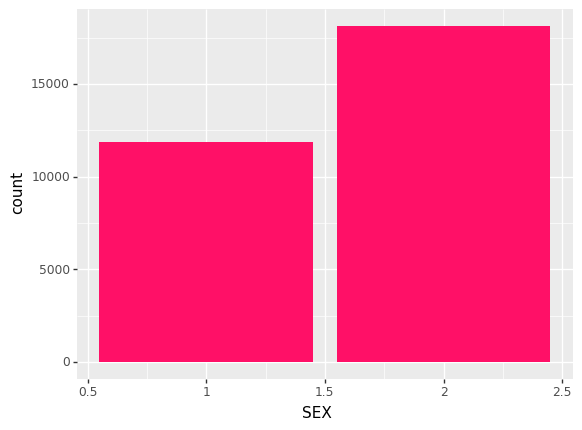

<ggplot: (8787712511817)>


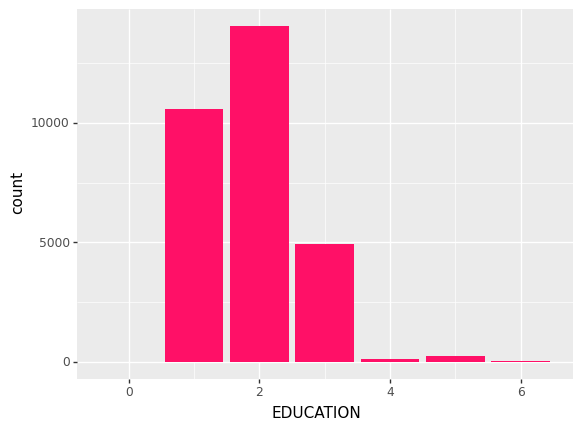

<ggplot: (8787713604793)>


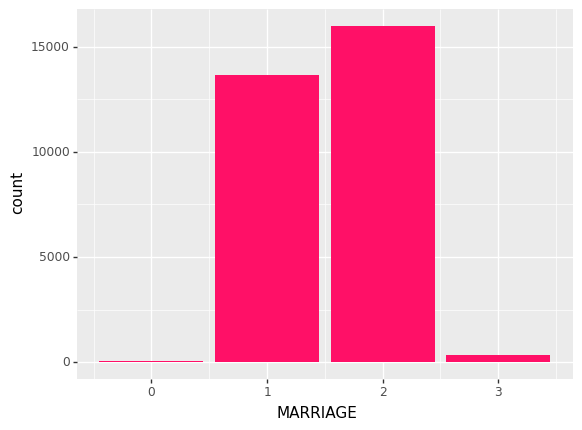

<ggplot: (8787713684329)>


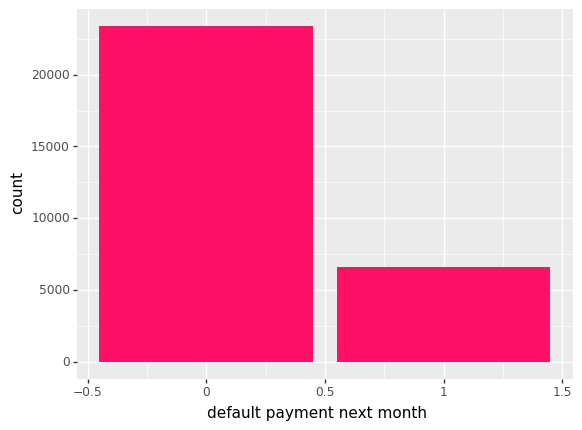

<ggplot: (8787710383501)>


In [60]:
# Bar graphs
for i in Cat_data:
  print(ggplot(sql_df.toPandas())+aes(i,color=i)+geom_bar(fill = "#FF1067"))


**Treatment of classes with close to 0 observations. We either remove them or add them to nearest majority class.**

In [61]:
df2 = sql_df.toPandas()

In [62]:
df2['MARRIAGE']=df2['MARRIAGE'].replace({3:1,2:1,1:0})

In [63]:
df2['EDUCATION'] = df2['EDUCATION'].replace({1:0,2:1,3:2,4:2,5:2,6:2})
df2['EDUCATION'].value_counts()

1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64

In [64]:
df2['SEX']= df2['SEX'].replace({2:1,1:0})
df2['SEX'].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

In [65]:
distinct_values(df2)

SEX Distinct Values :  
 1    18112
0    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 1    16287
0    13713
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 8        2
 1        2
Name: PAY_4, dtype: int64 



* We can see that our dependent variable has a majority class. We need to pick model and algorithms complying to that in future.

###**Bivariate analysis**

####**Education by Gender**

In [66]:
Education_by_gender = pd.pivot_table(df2,index='EDUCATION',columns='SEX',aggfunc={'SEX':'count'})
Education_by_gender

SEX      
SEX           0     1
EDUCATION            
0          4362  6237
1          5374  8656
2          2152  3219

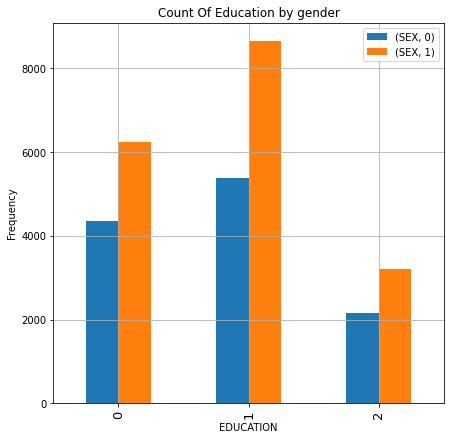

In [67]:
Education_by_gender.plot(kind='bar',figsize=(7,7),grid=1)
plt.title("Count Of Education by gender")
plt.ylabel('Frequency')
plt.legend()

* We can see in the above chart that people with University level education are highest in numbers.

####**People who defaulted groups in diffrent categories**


In [68]:
# Default by education
Default_by_education = pd.DataFrame(pd.pivot_table(df2,index='EDUCATION',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_education

default payment next month      
default payment next month                          0     1
EDUCATION                                                  
0                                                8563  2036
1                                               10700  3330
2                                                4101  1270

Text(0.5, 1.0, 'Count of People who defaulted by education')

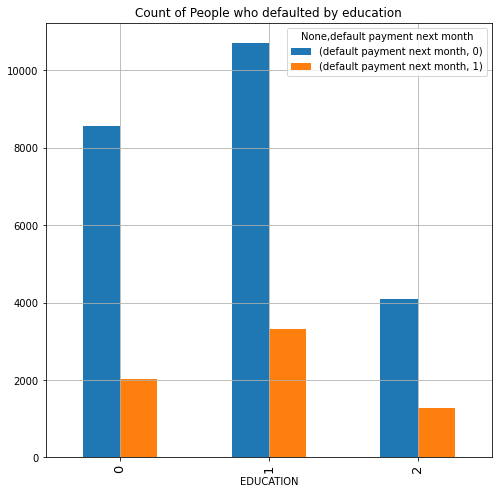

In [69]:
Default_by_education.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8),grid=1)

plt.title('Count of People who defaulted by education')

In [70]:
# Default by gender
Default_by_gender = pd.DataFrame(pd.pivot_table(df2,index='SEX',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_gender

default payment next month      
default payment next month                          0     1
SEX                                                        
0                                                9015  2873
1                                               14349  3763

Text(0.5, 1.0, 'Count of People who defaulted by gender')

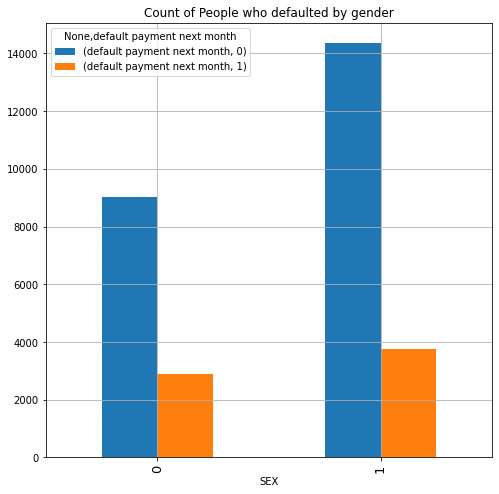

In [71]:
Default_by_gender.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8),grid=1)

plt.title('Count of People who defaulted by gender')

####**Treatment of Past payments due columns**

In [72]:
payments = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for i in payments:
  df2[i] = df2[i].replace({8:3,7:3,6:3,5:3,4:3})
  df2[i]= np.array(df2[i])+2
  print(df2[i].value_counts())

2    14737
1     5686
3     3688
0     2759
4     2667
5      463
Name: PAY_0, dtype: int64
2    15730
1     6050
4     3927
0     3782
5      483
3       28
Name: PAY_2, dtype: int64
2    15764
1     5938
0     4085
4     3819
5      390
3        4
Name: PAY_3, dtype: int64
2    16455
1     5687
0     4348
4     3159
5      349
3        2
Name: PAY_4, dtype: int64
2    16947
1     5539
0     4546
4     2626
5      342
Name: PAY_5, dtype: int64
2    16286
1     5740
0     4895
4     2766
5      313
Name: PAY_6, dtype: int64


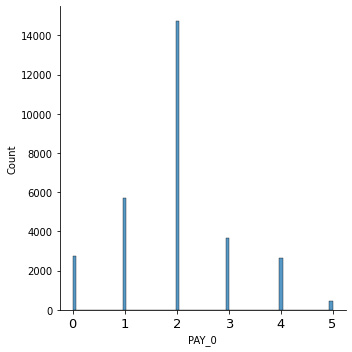

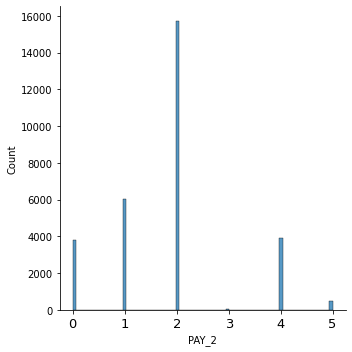

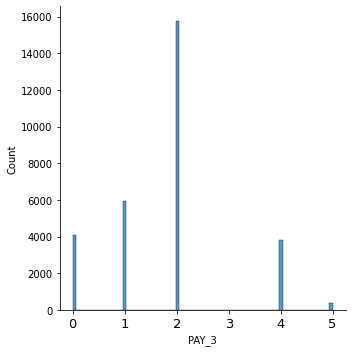

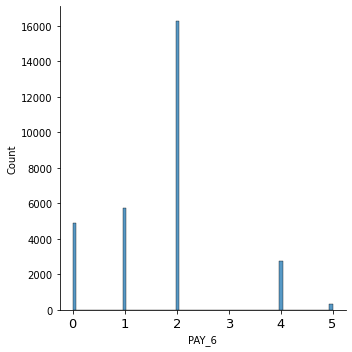

In [74]:
sns.displot(df2['PAY_0'],kde=0)
sns.displot(df2['PAY_2'],kde=0)
sns.displot(df2['PAY_3'],kde=0)
sns.displot(df2['PAY_6'],kde=0)


###**`AGE` Distribution**

In [ ]:
from scipy.stats import mode
mode_age = int(mode(df2['AGE'])[0])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



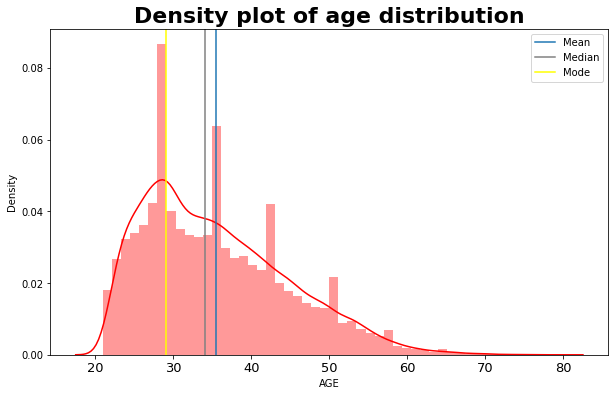

In [ ]:
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=13) 
sns.distplot(df2['AGE'],color='red')
plt.title('Density plot of age distribution',{'size':22,'weight':'bold'})
plt.axvline(np.mean(df2['AGE']),label='Mean')
plt.axvline(np.median(df2['AGE']),color='grey',label='Median')
plt.axvline(mode_age,color='yellow',label='Mode')
plt.legend()

* We can see that it is a skewed distribution.



* Even after trying square root transformation and log transformation it didn't come close to normal distribution

### `Limit Balance` Histogram Graph

In [80]:
pe.histogram(df2, x=(df2["LIMIT_BAL"]),marginal="box",facet_col='default payment next month',title='Limit Balance Histogram based on defaults payments',histnorm='probability density')

##Train test split 

In [ ]:
df2 = df2.iloc[:,1:]
df2.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,1,1,0,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,1,1,1,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,1,1,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,1,0,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,1,0,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [45]:
x = df2.drop('default payment next month',axis='columns')
y = df2['default payment next month']
print(f"{x.shape}\n {y.shape}")

(30000, 23)
 (30000,)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22500, 23)
(22500,)
(7500, 23)
(7500,)


###Logistic Regression Model

In [ ]:
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(max_iter=100000)

In [ ]:
logit.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
accuracy_score(y_train,logit.predict(x_train))

0.7772888888888889

In [ ]:
#Accuracy Score
accuracy_score(y_test,logit.predict(x_test))

0.7830666666666667

In [ ]:
# Classification Report
print(met.classification_report(y_test,logit.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5873
           1       0.00      0.00      0.00      1627

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.69      7500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt= DecisionTreeClassifier(class_weight="balanced")
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
accuracy_score(y_test,dt.predict(x_test))

0.7345333333333334

In [ ]:
print(met.classification_report(y_test,dt.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      5873
           1       0.39      0.38      0.38      1627

    accuracy                           0.73      7500
   macro avg       0.61      0.61      0.61      7500
weighted avg       0.73      0.73      0.73      7500



##Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gboost = GradientBoostingClassifier()
gboost.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
accuracy_score(y_train,gboost.predict(x_train))

0.8268444444444445

In [ ]:
accuracy_score(y_test,gboost.predict(x_test))

0.8196

In [ ]:
from sklearn.model_selection import GridSearchCV

#number of trees
n_estimators = [100,120]

#Maximum depth of tree
max_depth = [6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}


In [ ]:
gboost2= GradientBoostingClassifier()
gb_grid =GridSearchCV(estimator=gboost2, param_grid = param_dict,cv = 5, verbose=2)
gb_grid.fit(x_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.5s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.4s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.2s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  18.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  18.3s
[CV] max_depth=6, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 25.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [ ]:
accuracy_score(y_train,gb_grid.predict(x_train))

0.8477333333333333

In [ ]:
accuracy_score(y_test,gb_grid.predict(x_test))

0.8198666666666666

##Random Forest